In [185]:
# Program setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, mean_absolute_error, precision_recall_fscore_support, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

data = pd.read_csv("data/Dry_Bean_Dataset.csv")
seed = np.random.seed(14)

In [123]:
# Inspect data
print(data.shape)
data.head()

(13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [124]:
# Inpsect data
print(data.columns)
print(data.info())

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float

In [165]:
# Set X and y
X = data.copy()
y = X.pop('Class')
print(y.head())

feature_names = list(X.columns)
target_name = y.name
print(feature_names)
print(target_name)

0    SEKER
1    SEKER
2    SEKER
3    SEKER
4    SEKER
Name: Class, dtype: object
['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']
Class


In [126]:
# Check for missing values - no missing values
missing_values_count = data.isnull().sum()
print(missing_values_count)

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64


In [127]:
# Check values for 'Class' - all okay
unique_classes = data['Class'].unique()
print(unique_classes)

['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']


In [128]:
# Summary statistics
X.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860154,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64


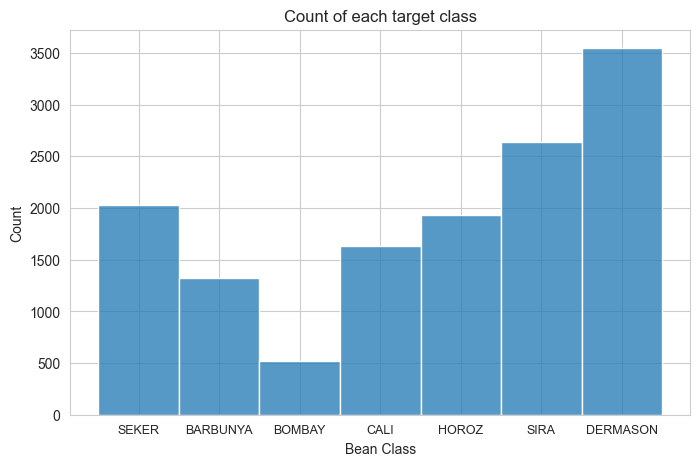

In [129]:
# Visualise distribution of target
sns.set_style('whitegrid')

plt.figure(figsize=(8,5))
plt.title('Count of each target class')
plt.xlabel('Bean Class')
plt.ylabel('Count')
plt.xticks(rotation=0, fontsize=9)
sns.histplot(y)

print(y.value_counts())

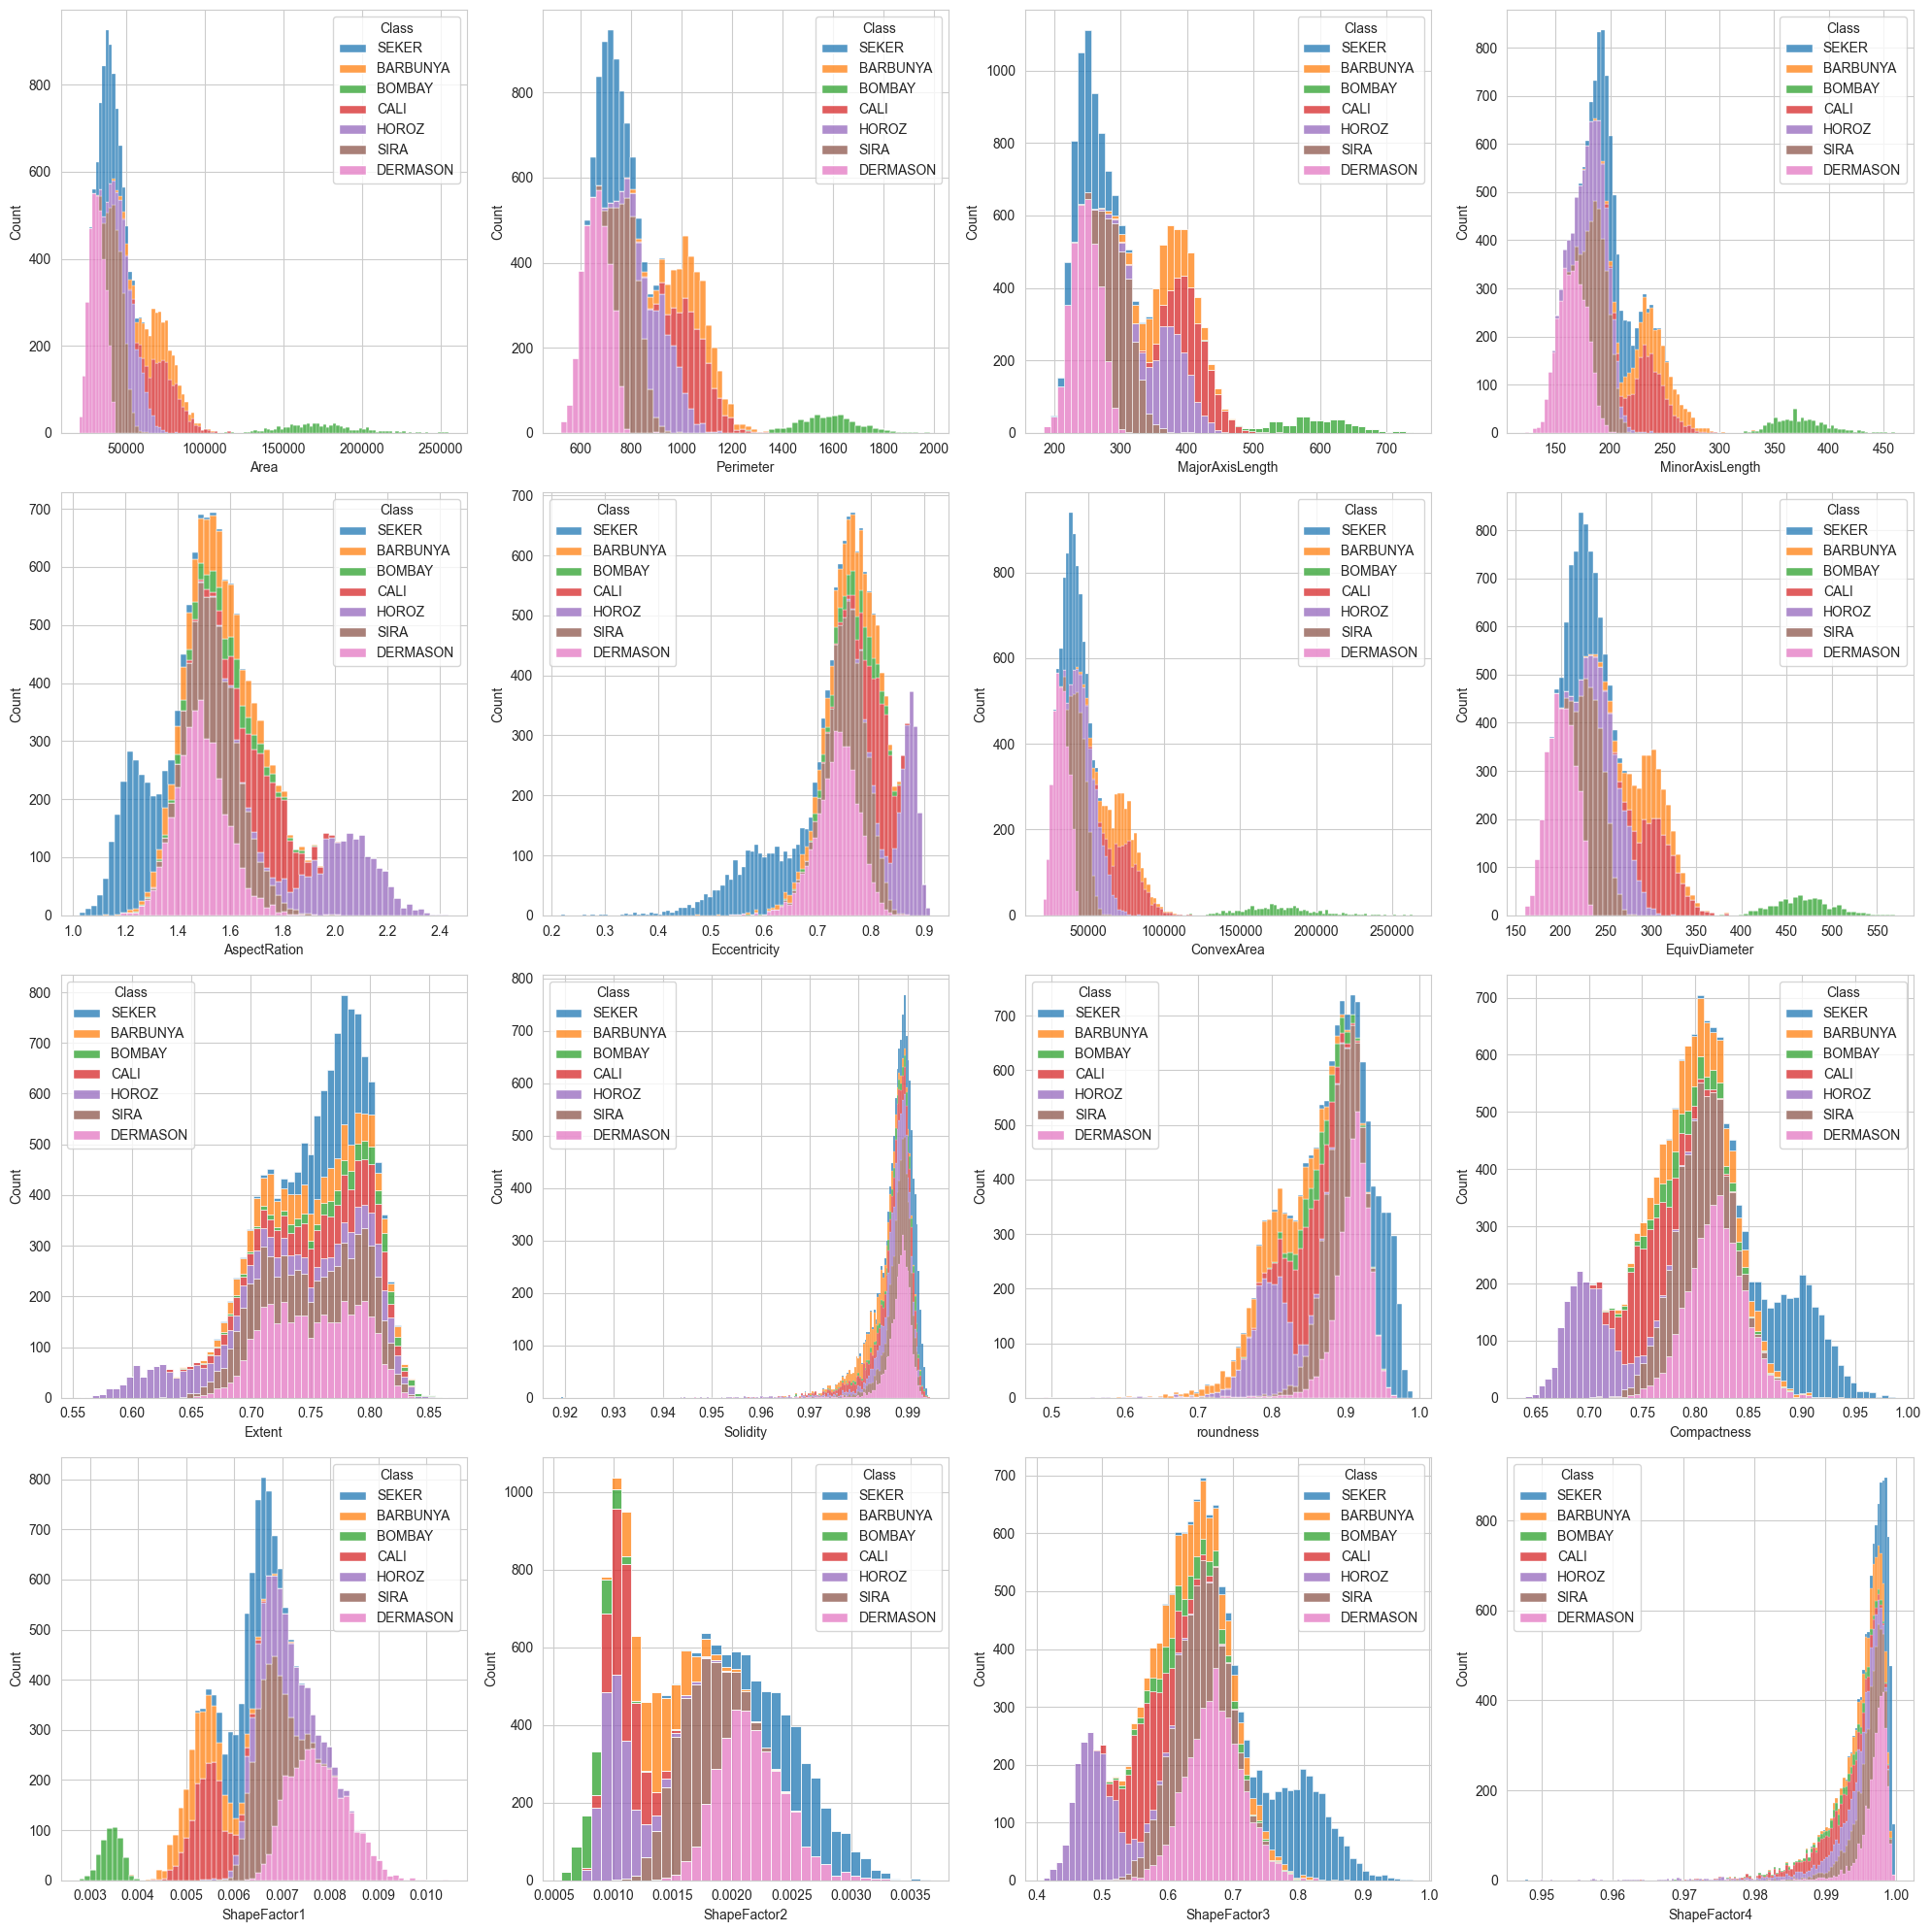

In [130]:
# # Visualise distributions of features
# fig, ax = plt.subplots(4,4, figsize=(20,20))

# for variable, subplot in zip(feature_names, ax.flatten()):
#     sns.histplot(data=data, x=variable, hue='Class', ax=subplot, multiple='stack')
# plt.tight_layout()

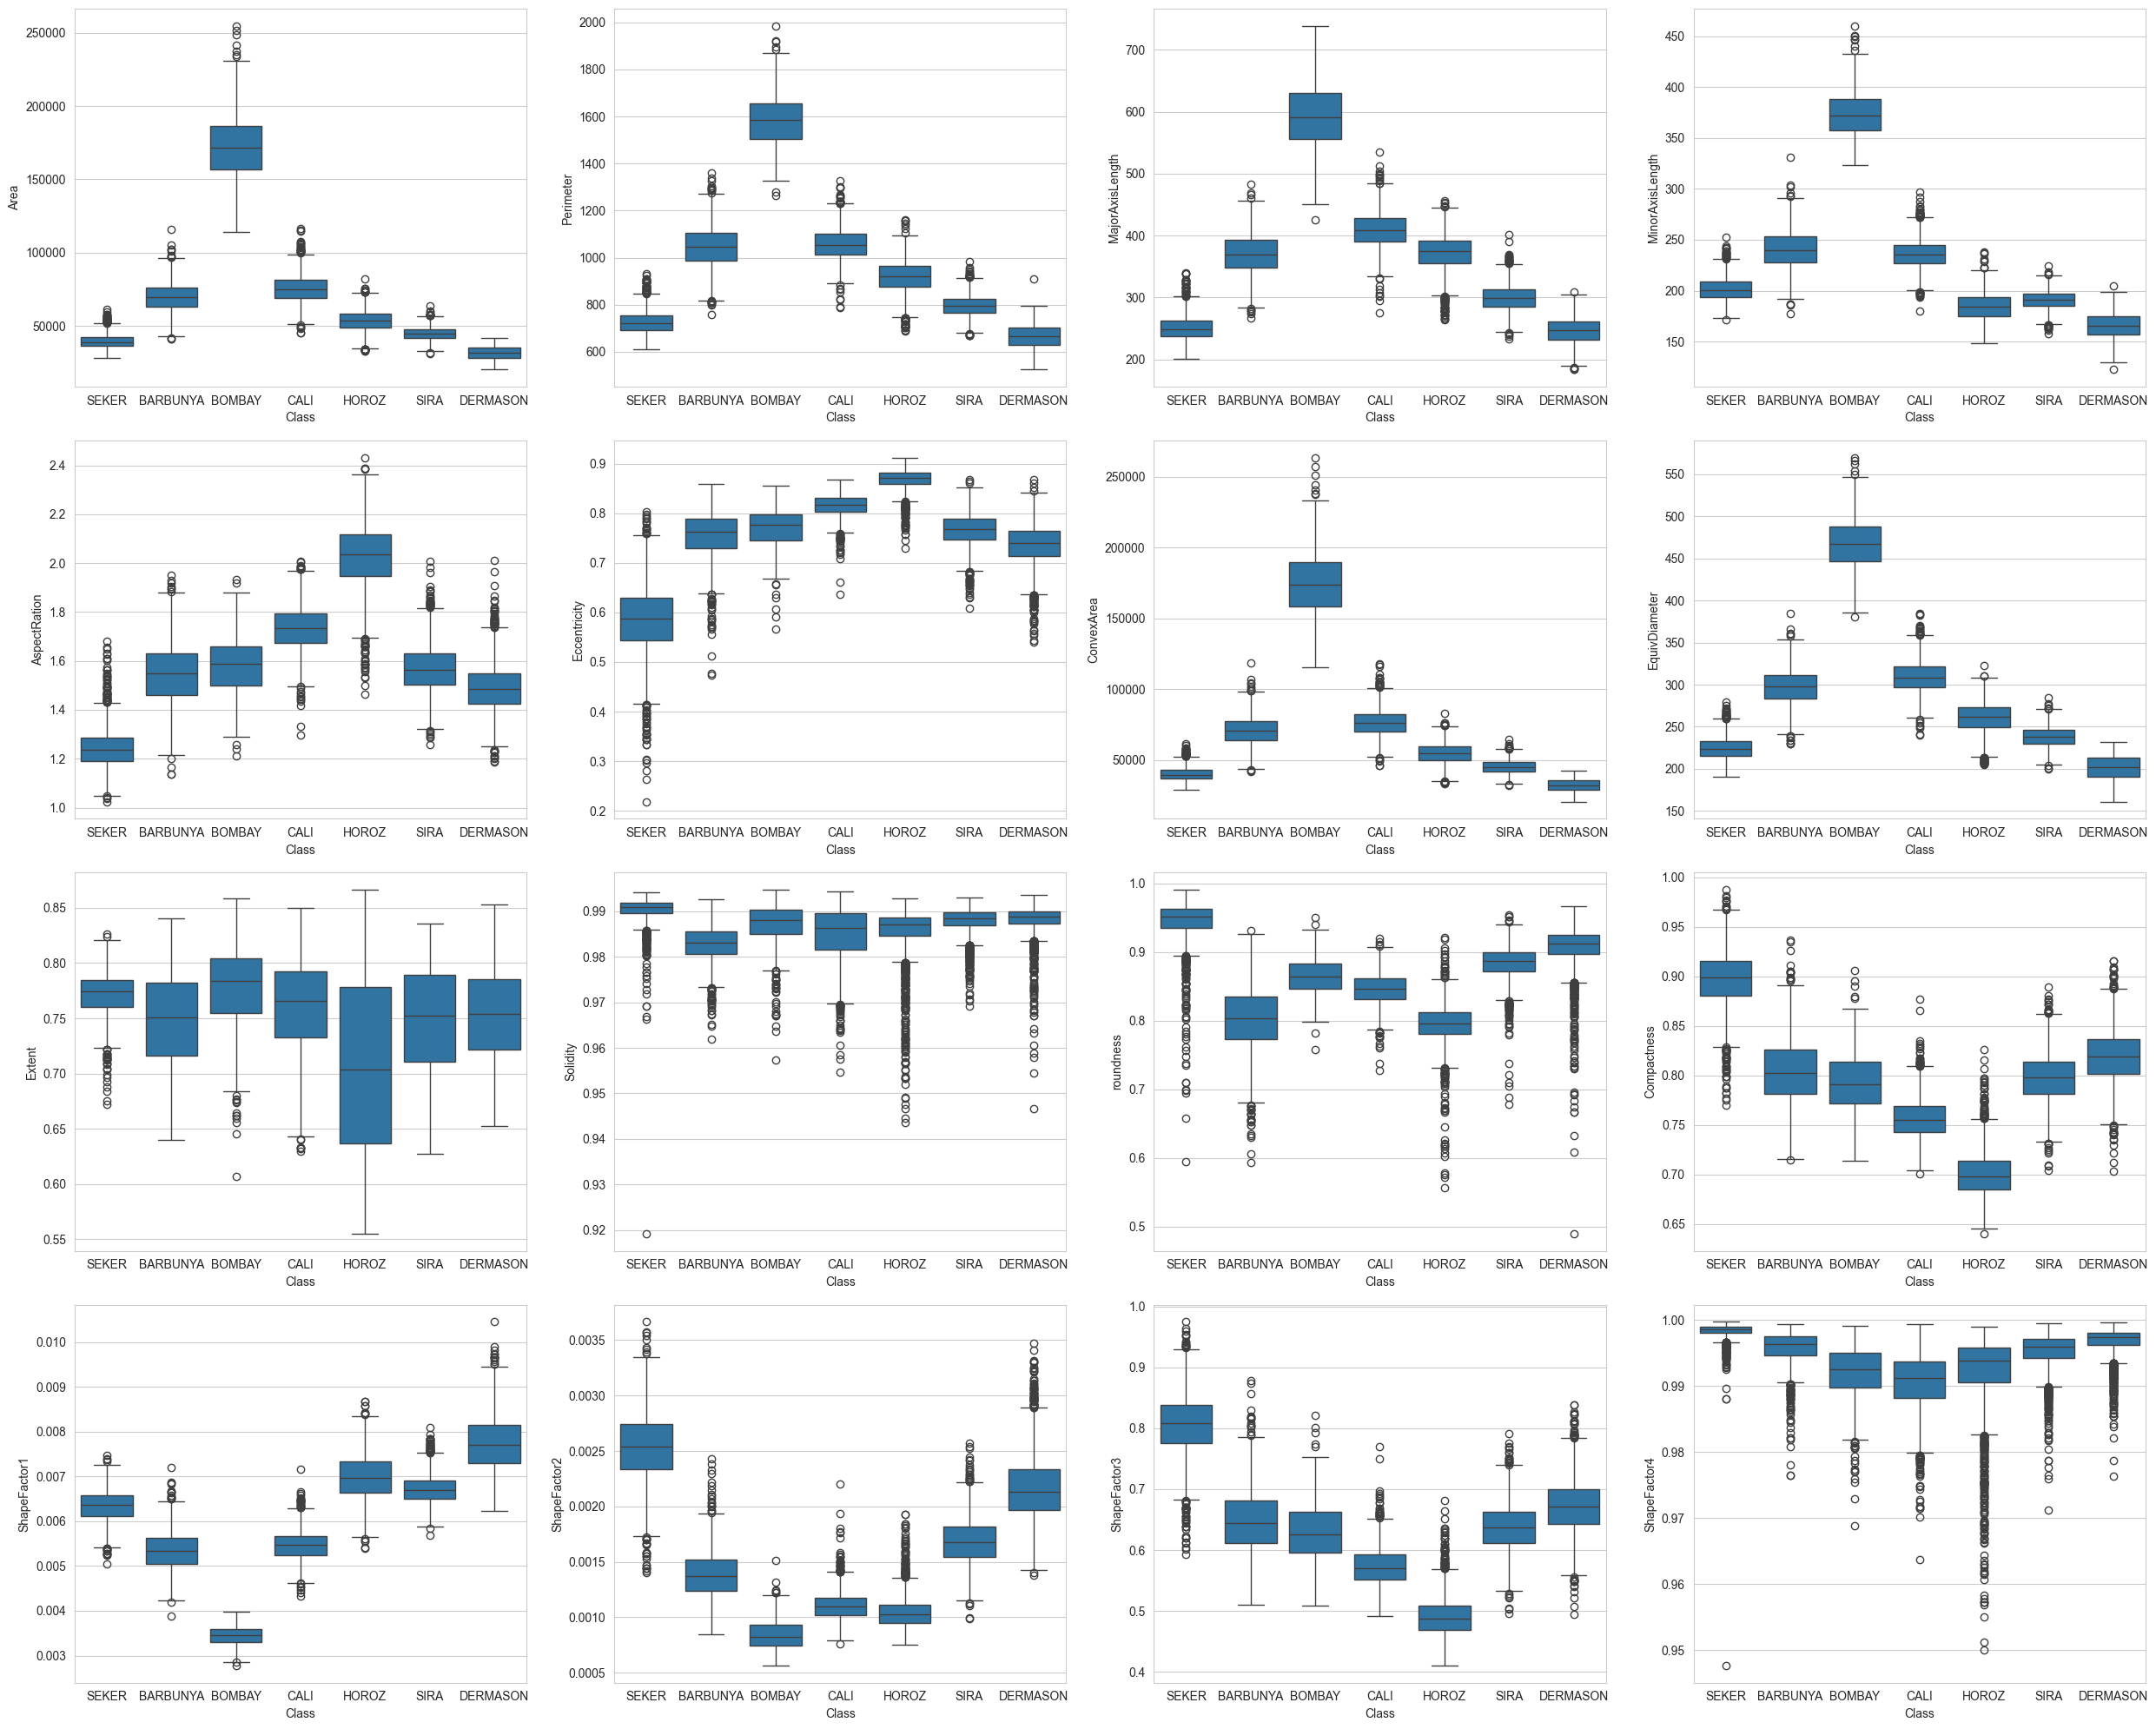

In [131]:
# # Check for outliers
# fig, ax = plt.subplots(4,4, figsize=(25,20))

# for variable, subplot in zip(feature_names, ax.flatten()):
#     sns.boxplot(x='Class', y=variable, data=data, ax=subplot)
# plt.tight_layout()

In [166]:
# Removing outliers
filt = (data['roundness'] > 0.5) | (data['Class'] != 'DERMASON')
data = data.loc[filt]

filt = (data['Solidity'] < 0.92) & (data['Class'] == 'SEKER')
data = data.loc[~filt]

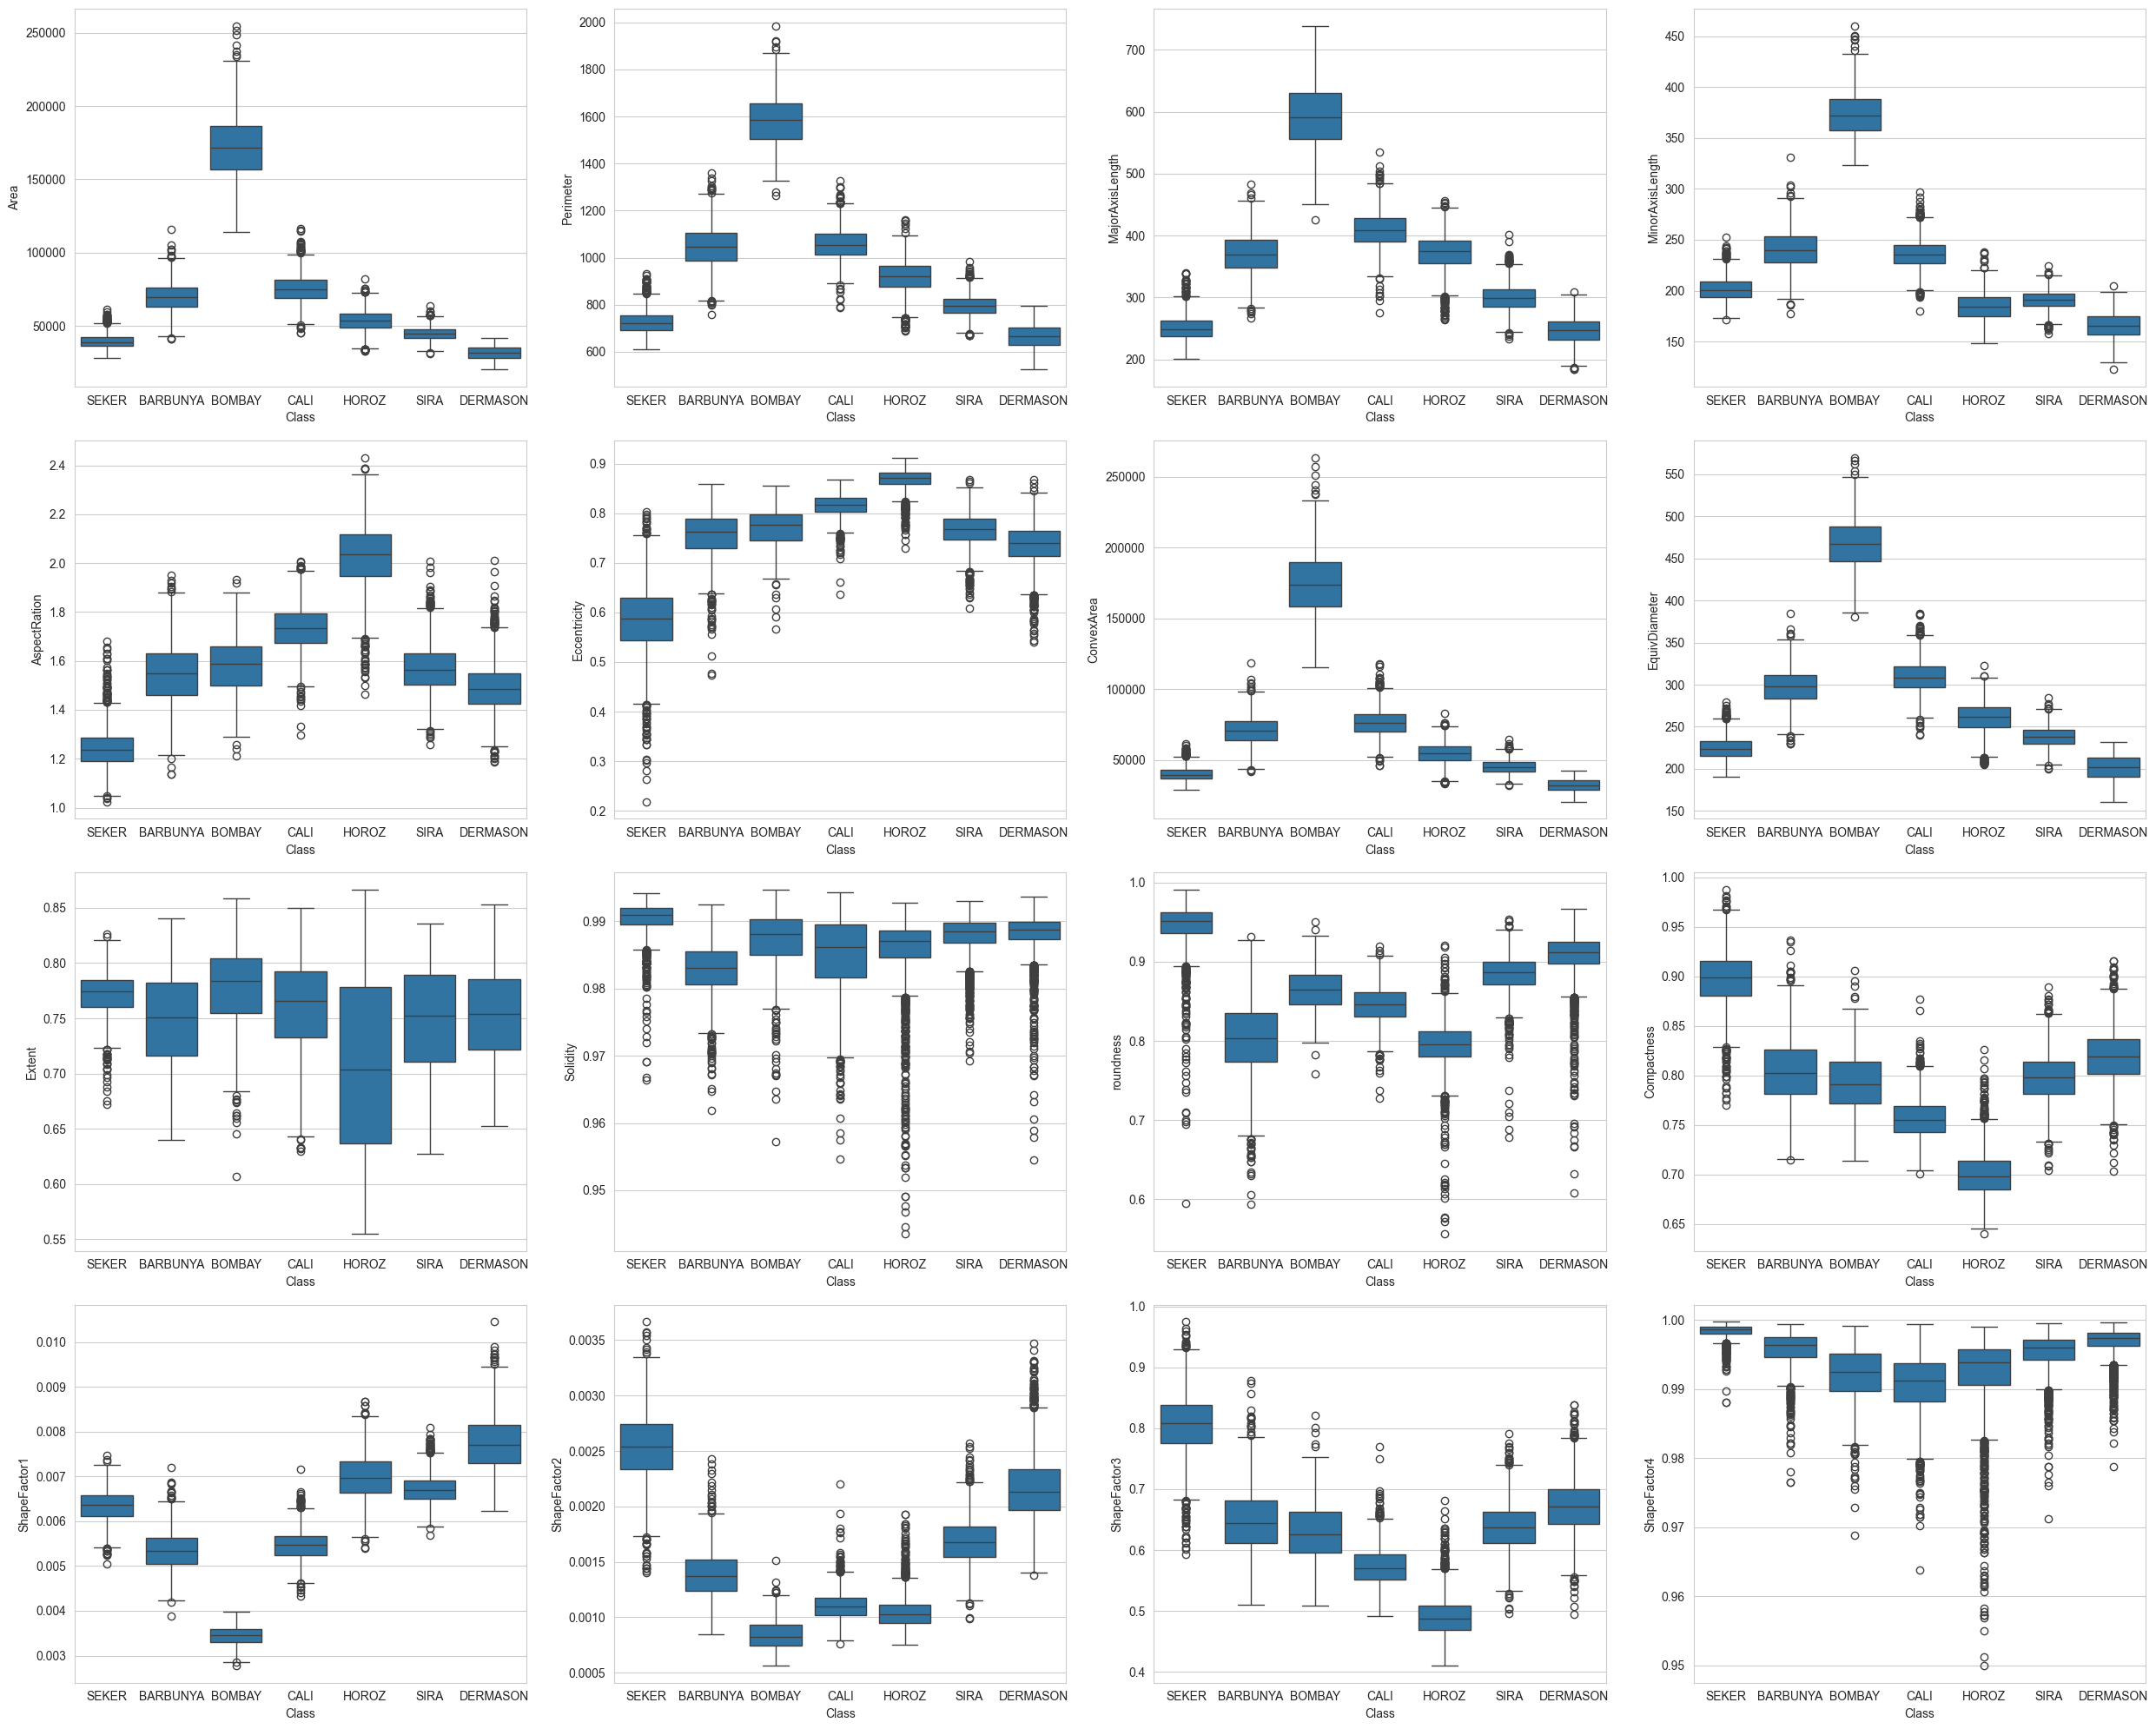

In [134]:
# # Show feature distributions with outliers removed
# fig, ax = plt.subplots(4,4, figsize=(25,20))

# for variable, subplot in zip(feature_names, ax.flatten()):
#     sns.boxplot(x='Class', y=variable, data=data, ax=subplot)
# plt.tight_layout()

In [175]:
# Label encoding target column
label_encoder = LabelEncoder()
data['Class'] = label_encoder.fit_transform(data['Class'])

unique_labels = data['Class'].unique()
print(unique_labels)

label_dict = {}
for i, classes in enumerate(unique_classes):
    label_dict[classes] = unique_labels[i]

print(label_dict)

[5 0 1 2 4 6 3]
{'SEKER': 5, 'BARBUNYA': 0, 'BOMBAY': 1, 'CALI': 2, 'HOROZ': 4, 'SIRA': 6, 'DERMASON': 3}


<Axes: xlabel='Class', ylabel='count'>

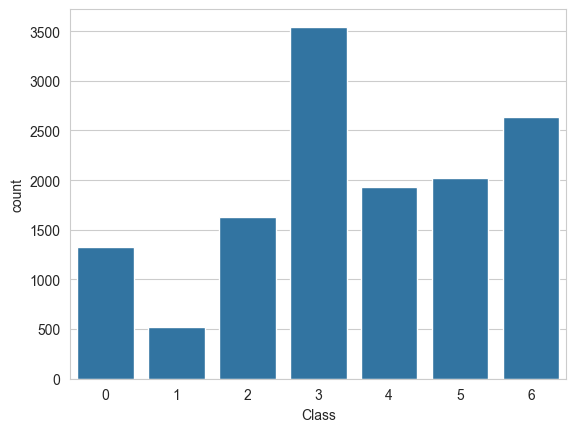

In [176]:
# Check labels are correct
sns.countplot(x=data['Class'])

In [177]:
# Data preprocessing - splitting data
X = data.copy()
y = X.pop('Class')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed)

In [178]:
# Imputing not needed, as no missing values
# Encoding not needed, as no categorical features
# Not making pipeline, as there is only the scaling step
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train.columns = feature_names

X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index)
X_valid.columns = feature_names
print(X_valid.head())
X_train_scaled.head()

           Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
10928 -0.838324  -0.483192        -1.112600        -0.879807     -0.823545   
5259   1.079540   1.165795         1.249308         1.183648      0.363140   
5966  -0.149168   0.048009         0.140258        -0.318668      0.753476   
10847 -0.849247  -1.051404        -0.914363        -1.190699      0.174959   
4199   0.510745   0.707468         0.558840         0.802358     -0.159182   

       Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
10928     -0.668645   -0.821986      -1.058143 -0.177542 -3.379326  -4.061853   
5259       0.550126    1.092493       1.271916  1.136316 -1.194263  -0.030064   
5966       0.802586   -0.148216      -0.068839  1.372813 -0.204610  -0.956781   
10847      0.408998   -0.848452      -1.076301 -0.506611  0.014240   0.308389   
4199       0.119202    0.530600       0.696587 -0.458160 -2.002674  -0.507066   

       Compactness  ShapeFactor1  ShapeFacto

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,-0.436464,-0.584320,-0.680920,-0.136125,-1.007323,-0.960910,-0.442767,-0.450043,0.602762,0.993280,1.280456,1.053598,-0.056127,0.885017,1.054740,0.800130
1,-0.988178,-1.278202,-1.159018,-1.399214,0.003274,0.267996,-0.987072,-1.315082,0.027397,0.077367,0.404324,-0.099204,2.288833,0.878637,-0.137031,0.677834
2,0.634029,1.082313,0.604661,0.981204,-0.297515,-0.017742,0.648432,0.826181,0.507510,-1.469456,-1.885264,0.192079,-1.211050,-0.544216,0.154438,-0.048320
3,3.418505,2.930421,2.499043,3.693523,-0.535939,-0.284985,3.411331,3.185716,0.813825,-0.086845,0.013237,0.428203,-2.719531,-1.193606,0.395507,-0.993706
4,-0.280557,-0.297237,-0.186107,-0.312469,0.132920,0.376604,-0.286113,-0.239017,-0.532299,0.733591,0.433972,-0.233611,0.195312,-0.206704,-0.269321,0.439798


In [179]:
# Decision Tree model
tree_model = DecisionTreeRegressor(random_state = seed)

tree_model.fit(X_train, y_train)

tree_y_preds = tree_model.predict(X_valid)

tree_mae = mean_absolute_error(y_valid, tree_y_preds)
print(f"Decision Tree MAE: {tree_mae}")

Decision Tree MAE: 0.3158977372906259


In [182]:
# Random Forest model
forest_model = RandomForestRegressor(random_state=seed)

forest_model.fit(X_train, y_train)

forest_y_preds = forest_model.predict(X_valid)

forest_mae = mean_absolute_error(y_valid, forest_y_preds)
print(f"Random Forest MAE: {forest_mae}")

Random Forest MAE: 0.27451660299735525


In [186]:
# XGBoost model
xgb_model = XGBRegressor(random_state = seed)

xgb_model.fit(X_train, y_train)

xgb_y_preds = xgb_model.predict(X_valid)

xgb_mae = mean_absolute_error(y_valid, xgb_y_preds)
print(f"XGBoost MAE: {xgb_mae}")

XGBoost MAE: 0.3322487282938927
